#**Convulation Neural Networks (CNN)**

**What will you learn?**
1. **Regularisation** : Dropout and keep probability.
2. **Implementaion using TensorFlow**
3. **Implementaion using Keras**

##**Regularisation using Dropout**

Large neural nets trained on relatively small datasets can overfit the training data.

This has the effect of the model learning the statistical noise in the training data, which results in poor performance when the model is evaluated on new data, e.g. a test dataset. Generalization error increases due to overfitting.

One approach to reduce overfitting is to fit all possible different neural networks on the same dataset and to average the predictions from each model. This is not feasible in practice, and can be approximated using a small collection of different models, called an ensemble. A problem even with the ensemble approximation is that it requires multiple models to be fit and stored, which can be a challenge if the models are large, requiring days or weeks to train and tune. Hence, we need a different method.

**Dropout** is a regularization method that approximates training a large number of neural networks with different architectures in parallel.

During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer.

Because the outputs of a layer under dropout are randomly subsampled, it has the effect of reducing the capacity or thinning the network during training. As such, a wider network, e.g. more nodes, may be required when using dropout.



##**Implementation using TensorFlow**

Lets begin the implementation of our very own CNN using TensorFlow. We will be using MNIST Dataset for this example.

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [4]:
input_width = 28
input_height = 28
input_channels = 1
input_pixels = 784

n_conv1 = 32
n_conv2 = 64
stride_conv1 = 1
stride_conv2 = 1
conv1_k = 5
conv2_k = 5
max_pool1_k = 2
max_pool2_k = 2

n_hidden = 1024
n_out = 10

input_size_to_hidden = (input_width//(max_pool1_k*max_pool2_k)) * (input_height//(max_pool1_k*max_pool2_k)) *n_conv2

In [5]:
weights = {
    "wc1" : tf.Variable(tf.random_normal([conv1_k, conv1_k, input_channels, n_conv1])),
    "wc2" : tf.Variable(tf.random_normal([conv2_k, conv2_k, n_conv1, n_conv2])),
    "wh1" : tf.Variable(tf.random_normal([input_size_to_hidden, n_hidden])),
    "wo" : tf.Variable(tf.random_normal([n_hidden, n_out]))
}

biases = {
    "bc1" : tf.Variable(tf.random_normal([n_conv1])),
    "bc2" : tf.Variable(tf.random_normal([n_conv2])),
    "bh1" : tf.Variable(tf.random_normal([n_hidden])),
    "bo" : tf.Variable(tf.random_normal([n_out])),
}

###**Max Pooling and Convulation Layers**

In [6]:
def conv(x, weights, bias, strides = 1):
    out = tf.nn.conv2d(x, weights, padding="SAME", strides = [1, strides, strides, 1])
    out = tf.nn.bias_add(out, bias)
    out = tf.nn.relu(out)
    return out

def maxpooling(x, k = 2):
    return tf.nn.max_pool(x, padding = "SAME", ksize = [1, k, k, 1], strides = [1, k, k, 1])

###**Forward Propogation**

In [7]:
def cnn(x, weights, biases, keep_prob):
    x = tf.reshape(x, shape = [-1 ,input_height, input_width, input_channels])
    conv1 = conv(x, weights['wc1'], biases['bc1'], stride_conv1)
    conv1_pool = maxpooling(conv1, max_pool1_k)
    
    conv2 = conv(conv1_pool, weights['wc2'], biases['bc2'], stride_conv2)
    conv2_pool = maxpooling(conv2, max_pool2_k)
    
    hidden_input = tf.reshape(conv2_pool, shape = [-1, input_size_to_hidden])
    hidden_output_before_activation = tf.add(tf.matmul(hidden_input, weights['wh1']), biases['bh1'])
    hidden_output_before_dropout = tf.nn.relu(hidden_output_before_activation)                           ## Output before Dropout
    hidden_output = tf.nn.dropout(hidden_output_before_dropout, keep_prob)                               ## Modified output after Dropout
   
    output = tf.add(tf.matmul(hidden_output, weights['wo']), biases['bo'])
    return output

In [8]:
x = tf.placeholder("float", [None, input_pixels])
y = tf.placeholder(tf.int32, [None, n_out])
keep_prob = tf.placeholder("float")                    ## Keep Probability for Dropout
pred = cnn(x, weights, biases, keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


###**Cost**

In [9]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels = y))

###**Optimiser**

In [10]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
optimize = optimizer.minimize(cost)

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [12]:
batch_size = 100
for i in range(25):
    num_batches = int(mnist.train.num_examples/batch_size)
    total_cost = 0
    for j in range(num_batches):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        c, _ = sess.run([cost,optimize], feed_dict={x:batch_x , y:batch_y, keep_prob:0.8})
        total_cost += c
    print(total_cost)

939980.5320558548
33607.14002266899
18276.154507018626
12979.375901556286
9699.845059920191
8033.077782252759
6614.453477013837
6685.9494850595875
6705.823414263699
5666.102925630422
4994.154555317797
4571.756633257504
4450.282735745741
4584.337092747285
3477.6972290374806
3704.5168009414447
3210.956807119894
2245.902770935717
2172.4660763130514
2703.6454246653875
2585.4434342656964
2517.7228983913365
2658.8623712404683
2043.4574958958979
2253.1087895750907


In [13]:
predictions = tf.argmax(pred, 1)
correct_labels = tf.argmax(y, 1)
correct_predictions = tf.equal(predictions, correct_labels)
predictions,correct_preds  = sess.run([predictions, correct_predictions], feed_dict={x:mnist.test.images,
                                              y:mnist.test.labels, keep_prob:1.0})
correct_preds.sum()

9856

As you can see, we are getting a very high accuracy of 98.56%

In [22]:
import numpy as np
labels = np.argmax(mnist.test.labels, axis = 1)

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels, predictions)

array([[ 976,    0,    0,    0,    0,    0,    3,    1,    0,    0],
       [   0, 1132,    0,    0,    1,    0,    0,    1,    1,    0],
       [   5,    2, 1016,    1,    0,    0,    1,    6,    1,    0],
       [   0,    0,    1, 1005,    0,    3,    0,    0,    0,    1],
       [   0,    2,    1,    0,  967,    0,    1,    0,    1,   10],
       [   1,    0,    0,    9,    0,  873,    5,    0,    3,    1],
       [   2,    2,    0,    0,    1,    0,  952,    0,    1,    0],
       [   0,    9,    5,    2,    0,    0,    0, 1006,    2,    4],
       [   2,    1,    3,    5,    1,    6,    1,    0,  950,    5],
       [   2,    6,    1,    6,    5,    4,    0,    4,    2,  979]])

In [24]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



##**Implementation using Keras**

Let us try and code the same model using Keras

In [25]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [26]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


###**Model**

In [27]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________

In [28]:
batch_size = 100
epochs = 25

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 51s 946us/sample - loss: 0.2800 - acc: 0.9181 - val_loss: 0.0700 - val_acc: 0.9790
Epoch 2/25
54000/54000 [==============================] - 49s 917us/sample - loss: 0.0797 - acc: 0.9756 - val_loss: 0.0499 - val_acc: 0.9850
Epoch 3/25
54000/54000 [==============================] - 48s 897us/sample - loss: 0.0615 - acc: 0.9806 - val_loss: 0.0417 - val_acc: 0.9890
Epoch 4/25
54000/54000 [==============================] - 49s 900us/sample - loss: 0.0512 - acc: 0.9839 - val_loss: 0.0419 - val_acc: 0.9877
Epoch 5/25
54000/54000 [==============================] - 49s 911us/sample - loss: 0.0429 - acc: 0.9869 - val_loss: 0.0344 - val_acc: 0.9893
Epoch 6/25
54000/54000 [==============================] - 48s 894us/sample - loss: 0.0372 - acc: 0.9883 - val_loss: 0.0362 - val_acc: 0.9895
Epoch 7/25
54000/54000 [==============================] - 48s 894us/sample - loss: 0.0336 - acc: 0.9891 -

In [34]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1] * 100, '%')

Test loss: 0.032748750287692294
Test accuracy: 99.12999868392944 %


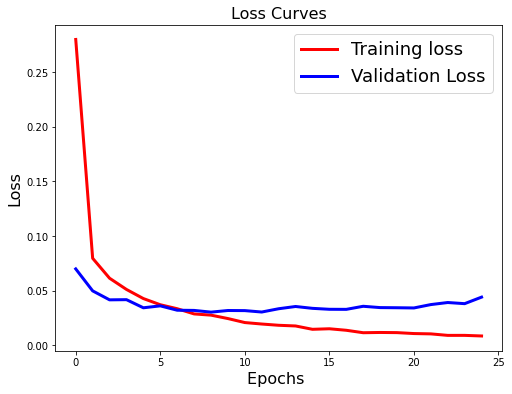

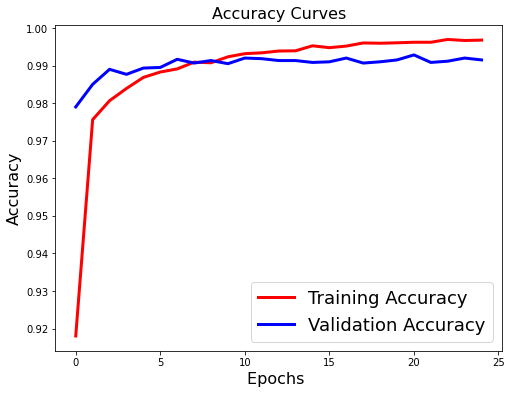

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)

plt.title('Accuracy Curves',fontsize=16)
plt.show()

##**Your Next Tasks**

Read the documentation of Keras and try to learn mre about various layers and their functionalities. How to use them and how to modify them for your model's gain.